In [1]:
%matplotlib inline

import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from scipy.signal import welch
from obspy import UTCDateTime
from pyproj import Proj
from datetime import datetime

### Load and plot data

This data was collected on a Sintela Onyx in June-July 2023 on the TERRA-SW cable owned and operated by GCI out of Homer, AK. The segment of channels shown here is about 500 m away from a CDIP wave buoy at the closest point, in water depth around 40 m. The cable direction is roughly E-W (080-092 varying with distance), and the wave direction is almost aways 30-60 degrees oblique to the cable. The tidal currents (as fast as +/- 1 m/s at 12 hr period) strongly modulate the wave spectrum. There is some leakage of swell into the Lower Cook Inlet at long periods, but the wave climate is generally insulated from the Pacific and determined by local wind conditions. Over the month of June, conditions are quite calm, with a mean wave period of 2-7 s and significant wave height of 0.2-1.2 m. 

In [3]:
fdir = '/Users/hglover/Library/CloudStorage/Box-Box/FiberExperiments/DAScomparison_paper/HomerAK_Williams/'
fname = 'GCI_TERRA_2p5Hz_data.h5'

with h5py.File(os.path.join(fdir,fname),'r') as fp:
    data_rad = fp['RawData'][:]
    time = fp['RawDataTime'][:]
    lon = fp['Longitude'][:]
    lat = fp['Latitude'][:]
    dep = fp['WaterDepth'][:]
    dx = fp['RawData'].attrs['ChannelPitch']
    fs = fp['RawData'].attrs['SamplingRate']
    gl = 17.5476194762 # gauge length, forgot to put it in the file
print(data_rad.shape)
print(fs)

(5832000, 65)
2.5


In [4]:
print(dx)

9.571428805203961


In [2]:
fdir = '.'#'/data/data1/GCI_OSGW_colab' # your path...
fname = 'GCI_TERRA_2p5Hz_data.h5'

with h5py.File(os.path.join(fdir,fname),'r') as fp:
    data_rad = fp['RawData'][:]
    time = fp['RawDataTime'][:]
    lon = fp['Longitude'][:]
    lat = fp['Latitude'][:]
    dep = fp['WaterDepth'][:]
    dx = fp['RawData'].attrs['ChannelPitch']
    fs = fp['RawData'].attrs['SamplingRate']
    gl = 17.5476194762 # gauge length, forgot to put it in the file

# get rid of nans - not ideal, but there are only 20 missing samples total
nx = data_rad.shape[1]
data_rad = data_rad[~np.isnan(data_rad)]
data_rad = data_rad.reshape((len(data_rad)//nx,nx))
time = time[~np.isnan(time)]

ns = data_rad.shape[0]
nx = data_rad.shape[1]

In [3]:
# From radians to strain
n = 1.4682
l = 1550.12e-9
data_e = data_rad * l/(2*np.pi*0.78*n*gl)
del data_rad

In [4]:
# Format dates
#ddateu = np.array([UTCDateTime(t*1e-6) for t in time]) # this is too memory intensive, tried on my laptop
#ddatem = np.array([d.matplotlib_date for d in ddateu])
ddatem = time * 1e-6 / (60*60*24)

Text(0, 0.5, 'Distance (m)')

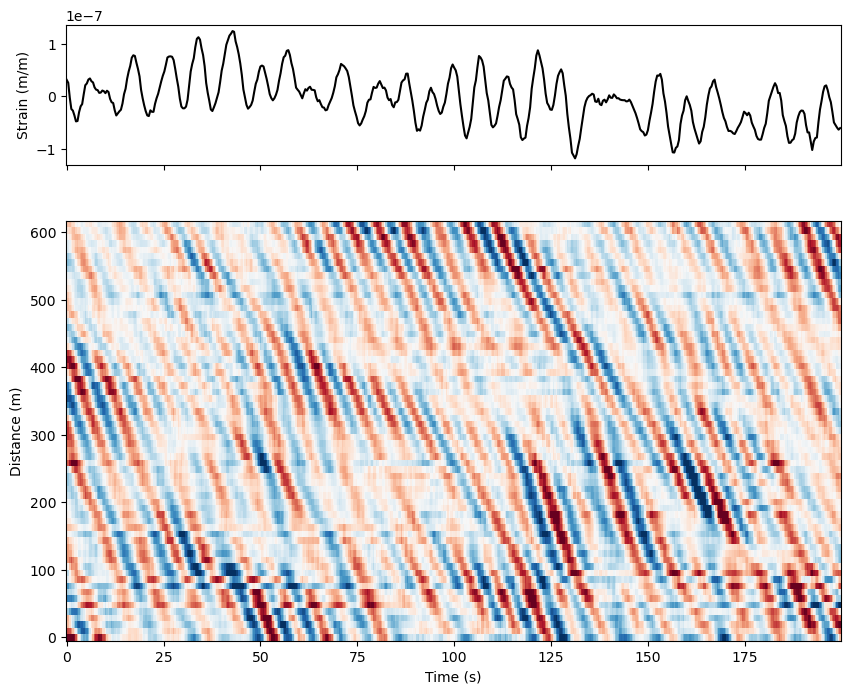

In [5]:
# Plot
fig,ax = plt.subplots(2,1,sharex=True,figsize=(10,8),height_ratios=[1,3])
ax[0].plot(np.arange(500)/fs,data_e[:500,10],'k')
ax[0].set_ylabel('Strain (m/m)')
ax[1].pcolormesh(np.arange(500)/fs,np.arange(nx)*dx,data_e[:500,:].T,cmap='RdBu',vmin=-1e-7,vmax=1e-7)
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Distance (m)')

### Load buoy data

The buoy data is split into three files. One file has the raw spectrum, another has the NDBC-calculated statistics, and the last has ADCP data. 

In [6]:
with h5py.File(os.path.join(fdir,'NDBC-46108_spectra.h5'),'r') as fp:
    sdate = fp['DATE'][:] # POSIX time stamp (ns)
    sfreq = fp['FREQ'][:] # Hz
    sspec = fp['SPEC'][:] # m^2/Hz

In [7]:
with h5py.File(os.path.join(fdir,'NDBC-46108_statistics.h5'),'r') as fp:
    ndate = fp['DATE'][:] # POSIX time stamp (ns)
    WVHT = fp['WVHT'][:] # significant wave height (m)
    SwH = fp['SwH'][:] # swell height (m)
    SwP = fp['SwP'][:] # swell period (s)
    WWH = fp['WWH'][:] # wind wave height (m)
    WWP = fp['WWP'][:] # wind wave period (s)
    SwD = fp['SwD'][:] # swell direction (N, NNW, NW, WNW, ...)
    WWD = fp['WWD'][:] # wind wave direction 
    APD = fp['APD'][:] # average wave period (s)
    MWD = fp['MWD'][:] # mean wave direction (deg)

In [8]:
with h5py.File(os.path.join(fdir,'NDBC-46108_adcp.h5'),'r') as fp:
    adate = fp['DATE'][:] # POSIX time stamp (ns)
    cdir = fp['DIR'][:] # flow direction at 1-m depth (deg)
    cspd = fp['SPD'][:] # flow speed at 1-m depth (cm/s)

In [9]:
# Convert date formats
sdateu = np.array([UTCDateTime(d*1e-9) for d in sdate])
ndateu = np.array([UTCDateTime(d*1e-9) for d in ndate])
adateu = np.array([UTCDateTime(d*1e-9) for d in adate])

sdatem = np.array([d.matplotlib_date for d in sdateu])
ndatem = np.array([d.matplotlib_date for d in ndateu])
adatem = np.array([d.matplotlib_date for d in adateu])

/tmp/ipykernel_630516/1252114568.py:4: RuntimeWarning: divide by zero encountered in log10
  ax[0].pcolormesh(sdatem,sfreq,np.log10(sspec).T,cmap='jet')


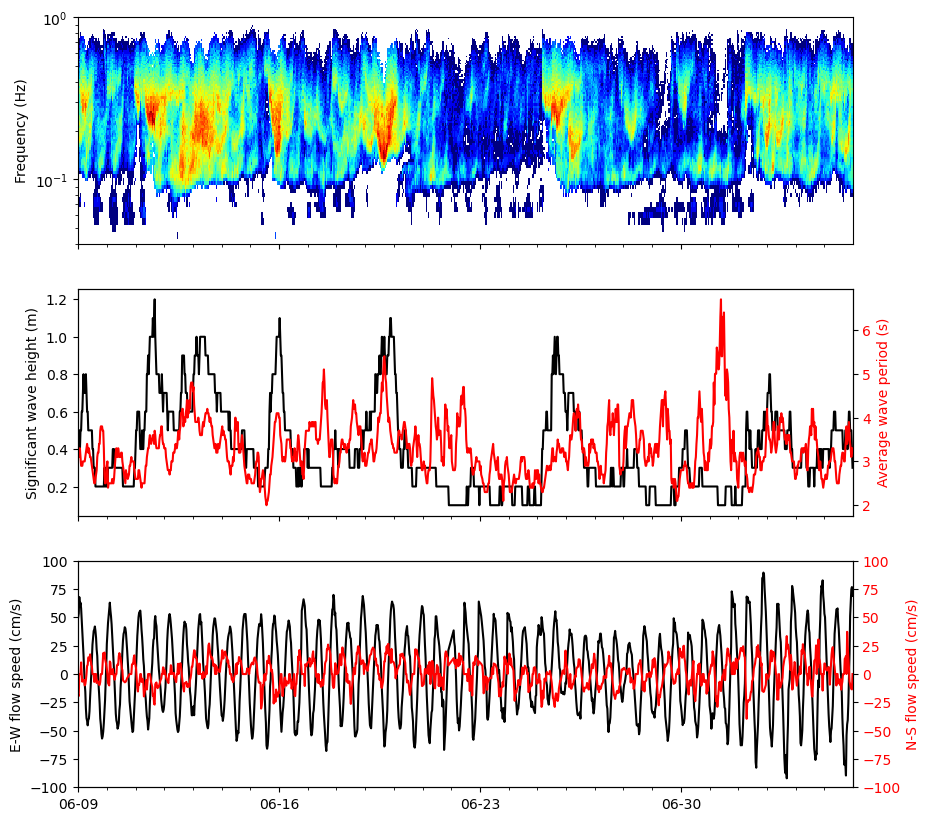

In [10]:
# Plot
date_form = DateFormatter("%m-%d")
fig,ax = plt.subplots(3,1,sharex=True,figsize=(10,10))
ax[0].pcolormesh(sdatem,sfreq,np.log10(sspec).T,cmap='jet')
ax[0].set_yscale('log')
ax[0].set_ylim([4e-2,1e0])
ax[0].set_ylabel('Frequency (Hz)')
ax[1].plot(ndatem,WVHT,'k',label='Hs')
ax[1].set_ylabel('Significant wave height (m)')
axx = ax[1].twinx()
axx.plot(ndatem,APD,'r')
axx.tick_params(axis='y',labelcolor='r')
axx.set_ylabel('Average wave period (s)',color='r')
ax[2].plot(adatem,cspd*np.cos(cdir*np.pi/180),'k')
ax[2].set_ylabel('E-W flow speed (cm/s)')
axx = ax[2].twinx()
axx.plot(adatem,cspd*np.sin(cdir*np.pi/180),'r')
axx.tick_params(axis='y',labelcolor='r')
axx.set_ylabel('N-S flow speed (cm/s)',color='r')
ax[2].set_ylim([-100,100]); axx.set_ylim([-100,100])
ax[0].xaxis.set_major_formatter(date_form)
ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax[0].xaxis.set_minor_locator(mdates.DayLocator(interval=1))

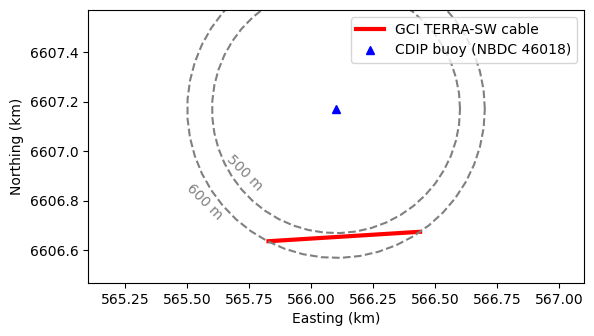

In [11]:
# Buoy coordinates
blon = -151.8291
blat = 59.5975

myProj = Proj('+proj=utm +zone=5 +ellps=WGS84 +datum=WGS84 +units=m +no_defs')
x,y = myProj(lon,lat)
bx,by = myProj(blon,blat)

x *= 1e-3; y *= 1e-3
bx *= 1e-3; by *= 1e-3

plt.figure()
plt.plot(x,y,c='r',linewidth=3,label='GCI TERRA-SW cable')
plt.plot(bx,by,'b^',label='CDIP buoy (NBDC 46018)')
plt.plot(bx+0.5*np.cos(np.linspace(0,2*np.pi)),by+0.5*np.sin(np.linspace(0,2*np.pi)),'gray',linestyle='--')
plt.plot(bx+0.6*np.cos(np.linspace(0,2*np.pi)),by+0.6*np.sin(np.linspace(0,2*np.pi)),'gray',linestyle='--')
plt.text(bx+0.56*np.cos(0.8*np.pi),by-0.56*np.sin(0.8*np.pi),'500 m',c='gray',rotation=-45)
plt.text(bx+0.76*np.cos(0.8*np.pi),by-0.76*np.sin(0.8*np.pi),'600 m',c='gray',rotation=-45)
plt.xlim([bx-1,bx+1])
plt.ylim([by-0.7,by+0.4])
plt.gca().set_aspect('equal')
plt.xlabel('Easting (km)')
plt.ylabel('Northing (km)')
plt.legend(loc='upper right')

### Calculate spectra


In [12]:
nt = len(sdate)     # number of buoy spectra
nns = int(200*fs)   # number of samples for each FFT (to match buoy resolution)
nnw = int(nns//2+1) # number of frequency samples in RFFT
nov = int(nns//2)   # overlap for Welch's method
nsg = int(30*60*fs) # number of samples in each window
nwn = int(nsg//nns) # number of FFTs in each window

# Calculate spectra
spec_e = np.zeros((nt,nnw,nx))
for it in range(nt):
    ii = np.argmin(abs(sdatem[it]-ddatem))
    i1 = np.maximum(0,ii-nsg//2)
    i2 = np.minimum(ns,ii+nsg//2)
    freq_e,spec_e[it,:,:] = welch(data_e[i1:i2,:],fs=fs,nperseg=nns,\
                          noverlap=nov,detrend='linear',scaling='density',axis=0)

# clear data variable from memory
del data_e

In [13]:
# Truncate buoy frequency precision at 1 mHz
sfreq2 = (sfreq*1e3).astype(int)*1e-3

# The buoy spectrum is irregularly sampled
# Cut out the samples to align, but perhaps there should be some re-normalization?
idx = np.zeros(len(sfreq2),dtype=int)
for i,fi in enumerate(sfreq2):
    idx[i] = np.argmin(abs(freq_e-fi))
freq2_e = freq_e[idx]  # Hz
spec2_e = spec_e[:,idx,:] # strain^2/Hz

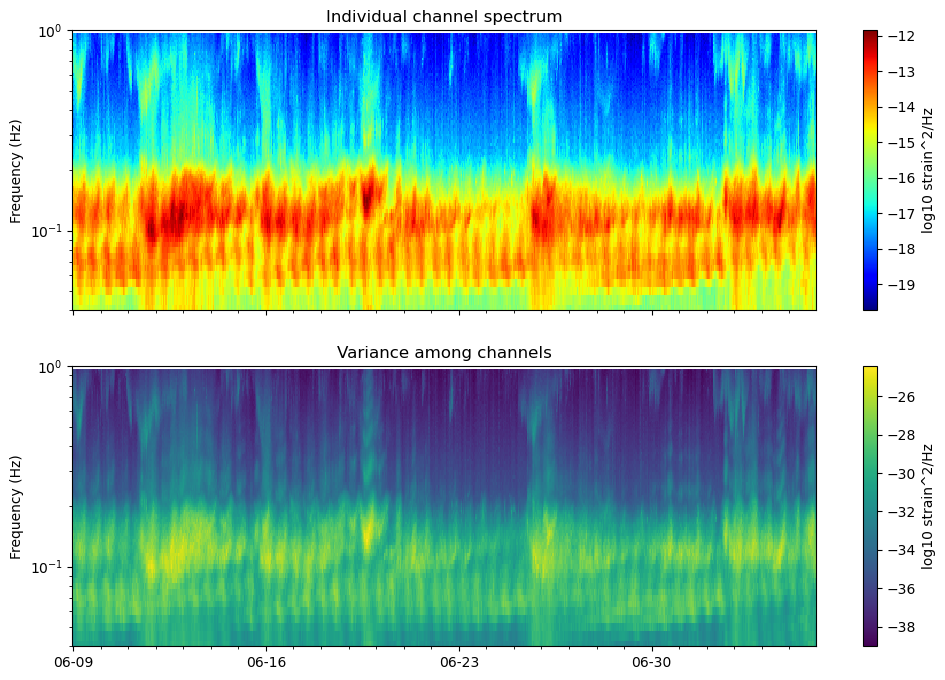

In [14]:
# Plot
fig,ax = plt.subplots(2,1,figsize=(12,8),sharex=True,sharey=True)
im0 = ax[0].pcolormesh(sdatem,sfreq,np.log10(spec2_e[:,:,30]).T,cmap='jet')
ax[0].set_yscale('log')
ax[0].set_ylim([4e-2,1e0])
ax[0].set_ylabel('Frequency (Hz)')
ax[0].set_title('Individual channel spectrum')
im1 = ax[1].pcolormesh(sdatem,sfreq,np.log10(np.std(spec2_e,axis=2)**2).T,cmap='viridis')
ax[1].set_ylabel('Frequency (Hz)')
ax[1].set_title('Variance among channels')
ax[1].xaxis.set_major_formatter(date_form)
ax[1].xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax[1].xaxis.set_minor_locator(mdates.DayLocator(interval=1))
fig.colorbar(im0,ax=ax[0],label='log10 strain^2/Hz')
fig.colorbar(im1,ax=ax[1],label='log10 strain^2/Hz')

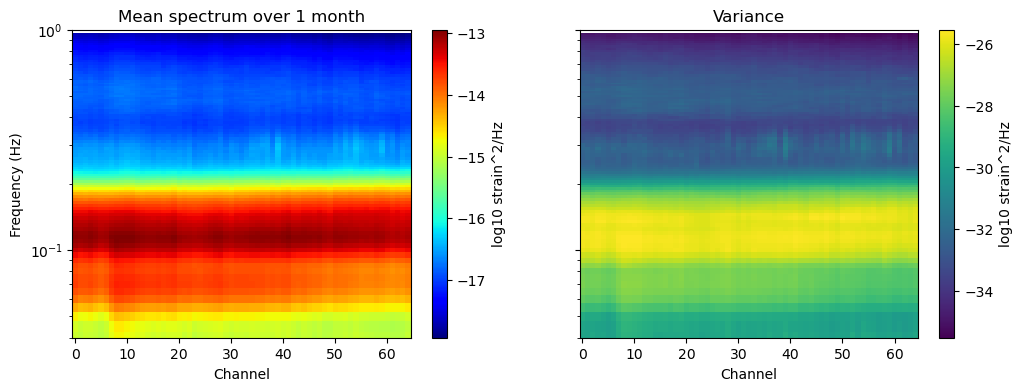

In [15]:
fig,ax = plt.subplots(1,2,figsize=(12,4),sharex=True,sharey=True)
im0 = ax[0].pcolormesh(np.arange(nx),sfreq,np.log10(np.mean(spec2_e,axis=0)),cmap='jet')
ax[0].set_yscale('log')
ax[0].set_ylim([4e-2,1e0])
ax[0].set_ylabel('Frequency (Hz)')
ax[0].set_xlabel('Channel')
ax[0].set_title('Mean spectrum over 1 month')
im1 = ax[1].pcolormesh(np.arange(nx),sfreq,np.log10(np.std(spec2_e,axis=0)**2),cmap='viridis')
ax[1].set_xlabel('Channel')
ax[1].set_title('Variance')
fig.colorbar(im0,ax=ax[0],label='log10 strain^2/Hz')
fig.colorbar(im1,ax=ax[1],label='log10 strain^2/Hz')

### Compare with buoy spectra

/tmp/ipykernel_630516/1640288432.py:7: RuntimeWarning: divide by zero encountered in divide
  ss = np.log10(spec2_e[:,:,ichan]/sspec)  # log10 spectral ratio
/home/ethan/anaconda3/envs/obspy/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ethan/anaconda3/envs/obspy/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ethan/anaconda3/envs/obspy/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ethan/anaconda3/envs/obspy/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/ethan/anaconda3/envs/obspy/lib/python3.11/site-packages/numpy/core/_meth

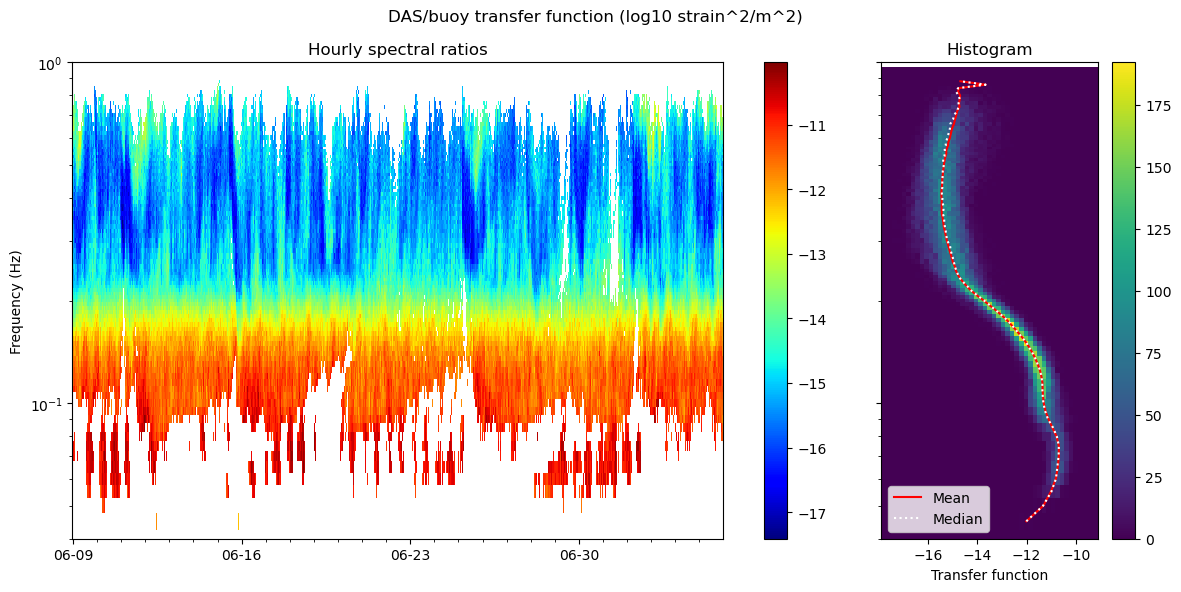

In [16]:
ichan = 31 # compare with the middle channel

# Histogram comparison of spectral ratios across the full month
a = np.linspace(-18,-9,50)              # psd bins
am = 0.5*(a[1:]+a[:-1])                  # psd bin centers
h = np.zeros((len(sfreq),len(a)-1))      # histogram
ss = np.log10(spec2_e[:,:,ichan]/sspec)  # log10 spectral ratio
m1 = np.zeros(len(sfreq)); m2 = np.zeros(len(sfreq)); std = np.zeros(len(sfreq))
for i in range(len(sfreq)):
    idx = np.logical_or(np.isinf(ss[:,i]),np.isnan(ss[:,i]))
    h[i,:],_ = np.histogram(ss[~idx,i],bins=a)
    m1[i] = np.mean(ss[~idx,i])   # mean
    m2[i] = np.median(ss[~idx,i]) # median
    std[i] = np.std(ss[~idx,i])   # standard deviation

# Plot
fig,ax = plt.subplots(1,2,figsize=(12,6),sharey=True,width_ratios=[3,1])
im0 = ax[0].pcolormesh(sdatem,sfreq,ss.T,cmap='jet')
ax[0].set_yscale('log')
ax[0].set_ylim([4e-2,1e0])
ax[0].set_ylabel('Frequency (Hz)')
ax[0].set_title('Hourly spectral ratios')
ax[0].xaxis.set_major_formatter(date_form)
ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax[0].xaxis.set_minor_locator(mdates.DayLocator(interval=1))
im1 = ax[1].pcolormesh(am,sfreq,h)
ax[1].plot(m1,sfreq,'r',label='Mean')
ax[1].plot(m2,sfreq,'w:',label='Median')
ax[1].legend(loc='lower left')
ax[1].set_xlim([min(am),max(am)])
ax[1].set_xlabel('Transfer function')
ax[1].set_title('Histogram')
fig.suptitle('DAS/buoy transfer function (log10 strain^2/m^2)')
fig.colorbar(im0,ax=ax[0])
fig.colorbar(im1,ax=ax[1])
fig.tight_layout()

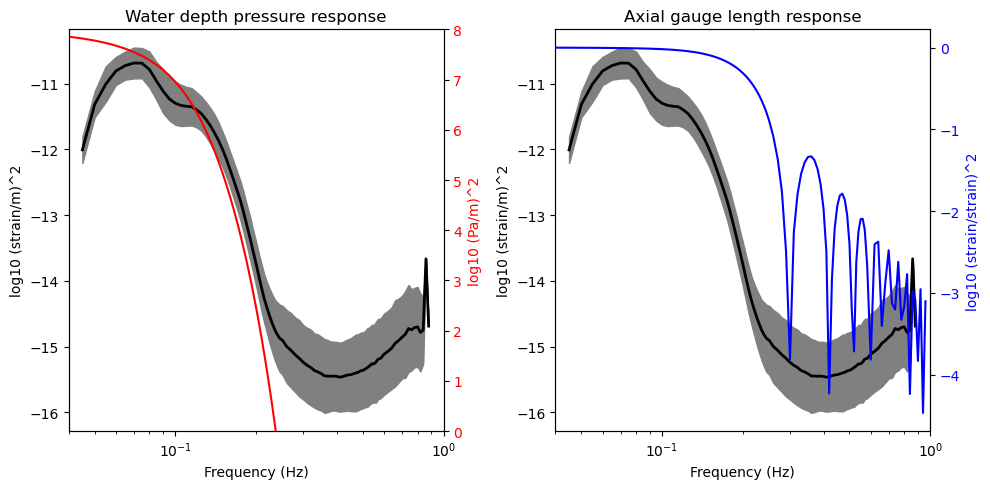

In [44]:
# Comparison with water depth and gauge length effects
depth = -1*dep[ichan]
rho = 1.0e3
g = 9.8
# interpolate dispersion
k_ = np.logspace(-4,1,300); w_ = np.sqrt(g*k_*np.tanh(k_*depth))
k = np.interp(sfreq,w_/2/np.pi,k_)
# (Pa/m)^2 pressure transfer function
Kp = (rho*g/np.cosh(k*depth))**2
# gauge length response for waves propagating along cable (strain/strain)^2
Kgl = (np.sin(k*gl/2)/(k*gl/2))**2

# Plot
fig, ax = plt.subplots(1,2,sharex=True,figsize=(10,5))
ax[0].fill_between(sfreq,m1-std,m1+std,color='gray')
ax[0].plot(sfreq,m1,'k',linewidth=2)
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('log10 (strain/m)^2')
ax[0].set_title('Water depth pressure response')
ax0 = ax[0].twinx()
ax0.plot(sfreq,np.log10(Kp),'r')
ax0.set_ylim([0,8])
ax0.set_ylabel('log10 (Pa/m)^2',color='r')
ax0.tick_params(axis='y',labelcolor='r')
ax[1].fill_between(sfreq,m1-std,m1+std,color='gray')
ax[1].plot(sfreq,m1,'k',linewidth=2)
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('log10 (strain/m)^2')
ax[1].set_title('Axial gauge length response')
ax1 = ax[1].twinx()
ax1.plot(sfreq,np.log10(Kgl),'b')
ax1.set_ylabel('log10 (strain/strain)^2',color='b')
ax1.tick_params(axis='y',labelcolor='b')
ax[1].set_xscale('log')
ax[1].set_xlim([4e-2,1e0])
fig.tight_layout()

/tmp/ipykernel_630516/1327739508.py:15: RuntimeWarning: Mean of empty slice
  mnm2[i,j] = np.nanmean(sss[~idx])


Text(0.5, 0, 'Tidal phase (deg)')

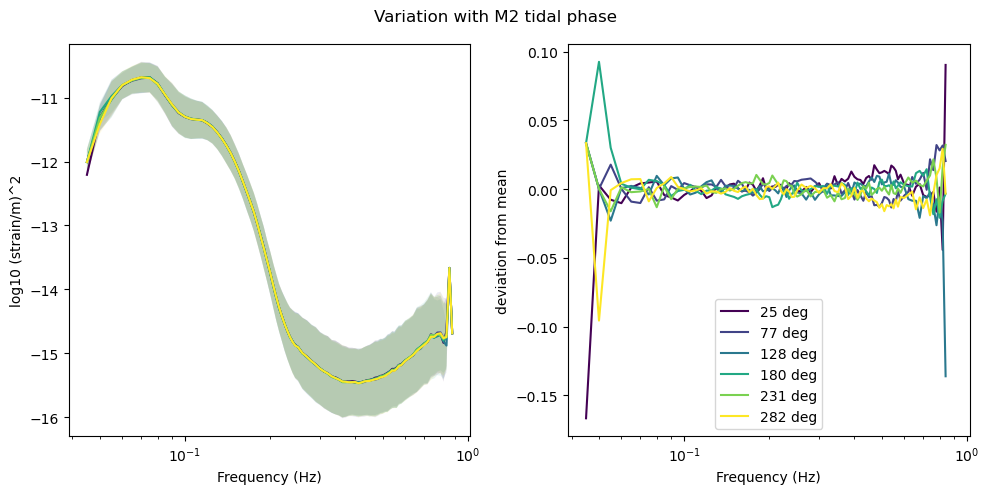

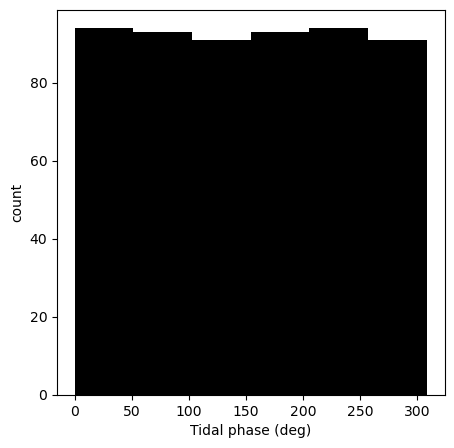

In [61]:
# Variation as a function of M2 tidal phase
fm2 = 2*np.pi*60*60/12.420601306150434         # M2 frequency in rad/s
pm2 = np.mod((sdateu - sdateu[0])/fm2,2*np.pi) # M2 phase in rad

Nm = 6
xp = 2*np.pi*np.arange(Nm+1)/(Nm+1) # bins
xm = (xp[1:]+xp[:-1])/2
mnm2 = np.zeros((Nm,len(sfreq)))
sdm2 = np.zeros((Nm,len(sfreq)))
for i in range(Nm):
    for j in range(len(sfreq)):
        idx = np.logical_and(pm2<xp[i+1],pm2>=xp[i])
        sss = ss[~idx,j]
        idx = np.logical_or(np.isinf(sss),np.isnan(sss))
        mnm2[i,j] = np.nanmean(sss[~idx])
        sdm2[i,j] = np.nanstd(sss[~idx])
        
# Plot
fig, ax = plt.subplots(1,2,figsize=(10,5),sharex=True)
colormap = plt.get_cmap('viridis')
ax[0].set_prop_cycle('color',[colormap(ic) for ic in np.linspace(0,1,Nm)])
ax[1].set_prop_cycle('color',[colormap(ic) for ic in np.linspace(0,1,Nm)])
for i in range(Nm):
    ax[0].fill_between(sfreq,mnm2[i,:]-sdm2[i,:],mnm2[i,:]+sdm2[i,:],alpha=0.1)
    ax[0].plot(sfreq,mnm2[i,:])
    ax[1].plot(sfreq,mnm2[i,:]-np.mean(mnm2,axis=0),label='%d deg' % (180*xm[i]/np.pi))
ax[0].set_xscale('log')
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('log10 (strain/m)^2')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('deviation from mean')
ax[1].legend()
fig.suptitle('Variation with M2 tidal phase')
fig.tight_layout()

plt.figure(figsize=(5,5))
plt.hist(pm2*180/np.pi,bins=xp*180/np.pi,color='k')
plt.ylabel('count')
plt.xlabel('Tidal phase (deg)')

/tmp/ipykernel_630516/1113491319.py:14: RuntimeWarning: Mean of empty slice
  mnwd[i,j] = np.nanmean(sss[~idx])


Text(0.5, 0, 'Mean wave direction (deg)')

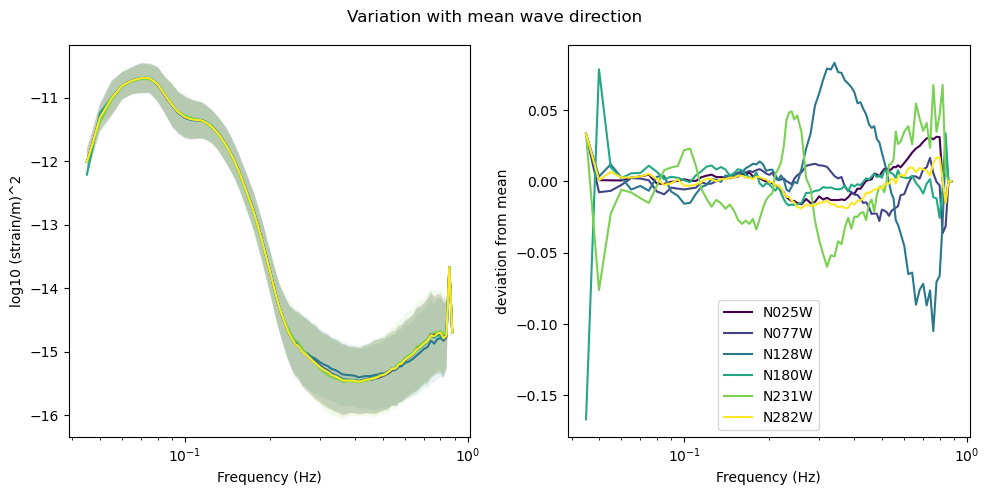

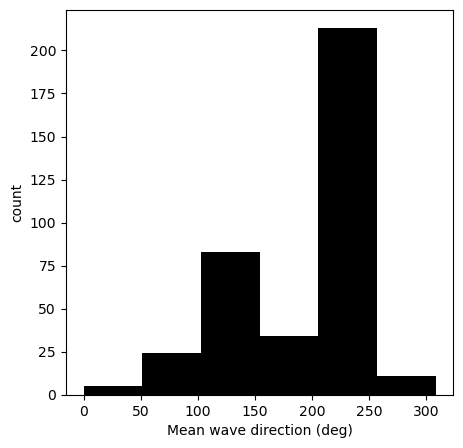

In [62]:
# Variation as a function of wave direction
MWD2 = np.interp(sdatem,ndatem,MWD)

Nm = 6
xp = 360*np.arange(Nm+1)/(Nm+1) # bins
xm = (xp[1:]+xp[:-1])/2
mnwd = np.zeros((Nm,len(sfreq)))
sdwd = np.zeros((Nm,len(sfreq)))
for i in range(Nm):
    for j in range(len(sfreq)):
        idx = np.logical_and(MWD2<xp[i+1],MWD2>=xp[i])
        sss = ss[~idx,j]
        idx = np.logical_or(np.isinf(sss),np.isnan(sss))
        mnwd[i,j] = np.nanmean(sss[~idx])
        sdwd[i,j] = np.nanstd(sss[~idx])

# Plot
fig, ax = plt.subplots(1,2,figsize=(10,5),sharex=True)
colormap = plt.get_cmap('viridis')
ax[0].set_prop_cycle('color',[colormap(ic) for ic in np.linspace(0,1,Nm)])
ax[1].set_prop_cycle('color',[colormap(ic) for ic in np.linspace(0,1,Nm)])
for i in range(Nm):
    ax[0].fill_between(sfreq,mnwd[i,:]-sdwd[i,:],mnwd[i,:]+sdwd[i,:],alpha=0.1)
    ax[0].plot(sfreq,mnwd[i,:])
    ax[1].plot(sfreq,mnwd[i,:]-np.mean(mnwd,axis=0),label='N%03dW' % xm[i])
ax[0].set_xscale('log')
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('log10 (strain/m)^2')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('deviation from mean')
ax[1].legend()
fig.suptitle('Variation with mean wave direction')
fig.tight_layout()

plt.figure(figsize=(5,5))
plt.hist(MWD2,bins=xp,color='k')
plt.ylabel('count')
plt.xlabel('Mean wave direction (deg)')

### Calculate and compare statistics

/tmp/ipykernel_630516/2961576027.py:6: RuntimeWarning: divide by zero encountered in log10
  im0 = ax[0].pcolormesh(sdatem,sfreq,np.log10(bspec).T,cmap='jet',vmin=-3,vmax=0)
/tmp/ipykernel_630516/2961576027.py:11: RuntimeWarning: divide by zero encountered in log10
  im1 = ax[1].pcolormesh(sdatem,sfreq,np.log10(sspec).T,cmap='jet',vmin=-3,vmax=0)


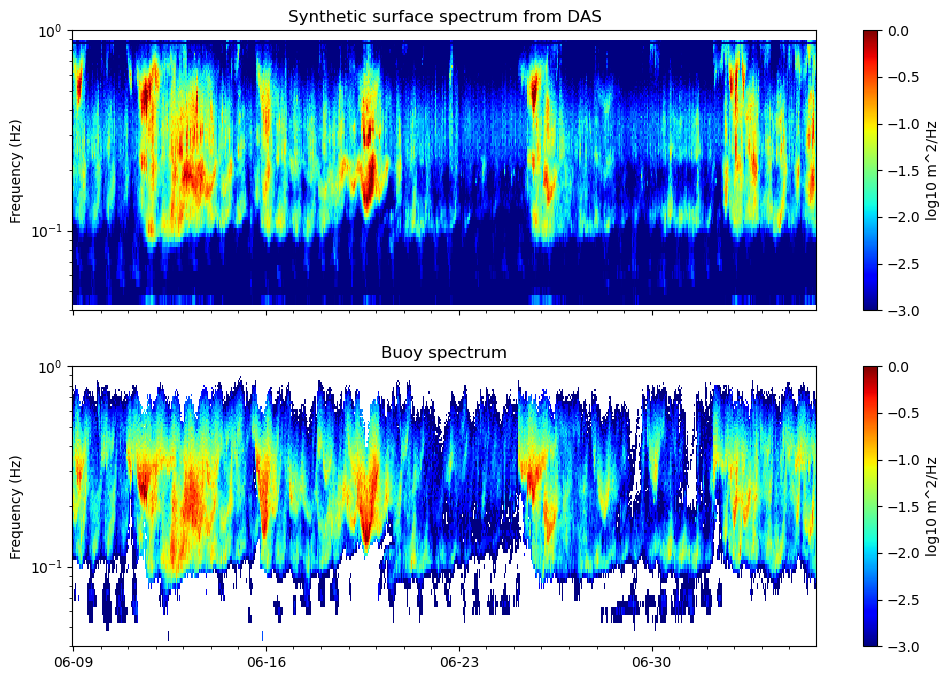

In [108]:
# Apply transfer function to DAS
bspec = spec2_e[:,:,ichan] * 10**-m1
bspec[np.isnan(bspec)] = 0

fig,ax = plt.subplots(2,1,figsize=(12,8),sharex=True,sharey=True)
im0 = ax[0].pcolormesh(sdatem,sfreq,np.log10(bspec).T,cmap='jet',vmin=-3,vmax=0)
ax[0].set_yscale('log')
ax[0].set_ylim([4e-2,1e0])
ax[0].set_ylabel('Frequency (Hz)')
ax[0].set_title('Synthetic surface spectrum from DAS')
im1 = ax[1].pcolormesh(sdatem,sfreq,np.log10(sspec).T,cmap='jet',vmin=-3,vmax=0)
ax[1].set_ylabel('Frequency (Hz)')
ax[1].set_title('Buoy spectrum')
ax[1].xaxis.set_major_formatter(date_form)
ax[1].xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax[1].xaxis.set_minor_locator(mdates.DayLocator(interval=1))
fig.colorbar(im0,ax=ax[0],label='log10 m^2/Hz')
fig.colorbar(im1,ax=ax[1],label='log10 m^2/Hz')

In [149]:
# Set frequency bounds
idx1Hz = np.logical_and(sfreq<=1.0,sfreq>=0.04)
idxp3Hz = np.logical_and(sfreq<=0.3,sfreq>=0.04)

# Periods from buoy spectra
Tp_buoy = np.array([1./sfreq[np.argmax(ss)] for ss in sspec])
Te_buoy_1Hz = np.array([1./np.sum(ss[idx1Hz]*sfreq[idx1Hz]/np.sum(ss[idx1Hz])) for ss in sspec])
Te_buoy_p3Hz = np.array([1./np.sum(ss[idxp3Hz]*sfreq[idxp3Hz]/np.sum(ss[idxp3Hz])) for ss in sspec])

# Periods from DAS spectra
Tp_DAS = np.array([1./sfreq[np.argmax(ss)] for ss in bspec])
Te_DAS_1Hz = np.array([1./np.sum(ss[idx1Hz]*sfreq[idx1Hz]/np.sum(ss[idx1Hz])) for ss in bspec])
Te_DAS_p3Hz = np.array([1./np.sum(ss[idxp3Hz]*sfreq[idxp3Hz]/np.sum(ss[idxp3Hz])) for ss in bspec])

# Wave heights
df = np.concatenate(([0],(sfreq[1:] - sfreq[:-1])/2),axis=0)
Hs_buoy_1Hz = np.array([4*np.sqrt(np.sum(ss[idx1Hz]*df[idx1Hz])) for ss in sspec])
Hs_buoy_p3Hz = np.array([4*np.sqrt(np.sum(ss[idxp3Hz]*df[idxp3Hz])) for ss in sspec])
Hs_DAS_1Hz = np.array([4*np.sqrt(np.sum(ss[idx1Hz]*df[idx1Hz])) for ss in bspec])
Hs_DAS_p3Hz = np.array([4*np.sqrt(np.sum(ss[idxp3Hz]*df[idxp3Hz])) for ss in bspec])


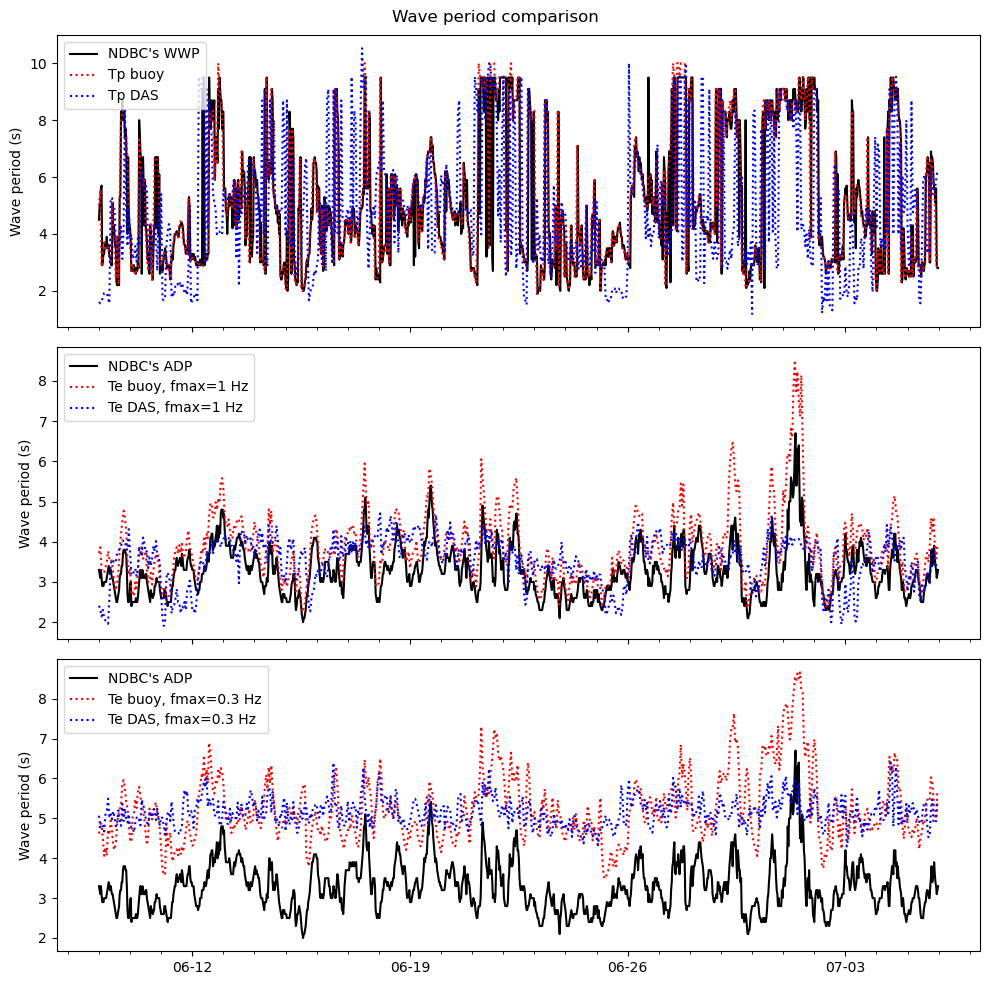

In [150]:
# Plot
fig,ax = plt.subplots(3,1,sharex=True,figsize=(10,10))
ax[0].plot(ndatem,WWP,'k',label='NDBC\'s WWP')
ax[0].plot(sdatem,Tp_buoy,'r:',label='Tp buoy')
ax[0].plot(sdatem,Tp_DAS,'b:',label='Tp DAS')
ax[0].set_ylabel('Wave period (s)')
ax[0].legend()
ax[1].plot(ndatem,APD,'k',label='NDBC\'s ADP')
ax[1].plot(sdatem,Te_buoy_1Hz,'r:',label='Te buoy, fmax=1 Hz')
ax[1].plot(sdatem,Te_DAS_1Hz,'b:',label='Te DAS, fmax=1 Hz')
ax[1].set_ylabel('Wave period (s)')
ax[1].legend()
ax[2].plot(ndatem,APD,'k',label='NDBC\'s ADP')
ax[2].plot(sdatem,Te_buoy_p3Hz,'r:',label='Te buoy, fmax=0.3 Hz')
ax[2].plot(sdatem,Te_DAS_p3Hz,'b:',label='Te DAS, fmax=0.3 Hz')
ax[2].set_ylabel('Wave period (s)')
ax[2].legend()
ax[0].xaxis.set_major_formatter(date_form)
ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax[0].xaxis.set_minor_locator(mdates.DayLocator(interval=1))
fig.suptitle('Wave period comparison')
fig.tight_layout()

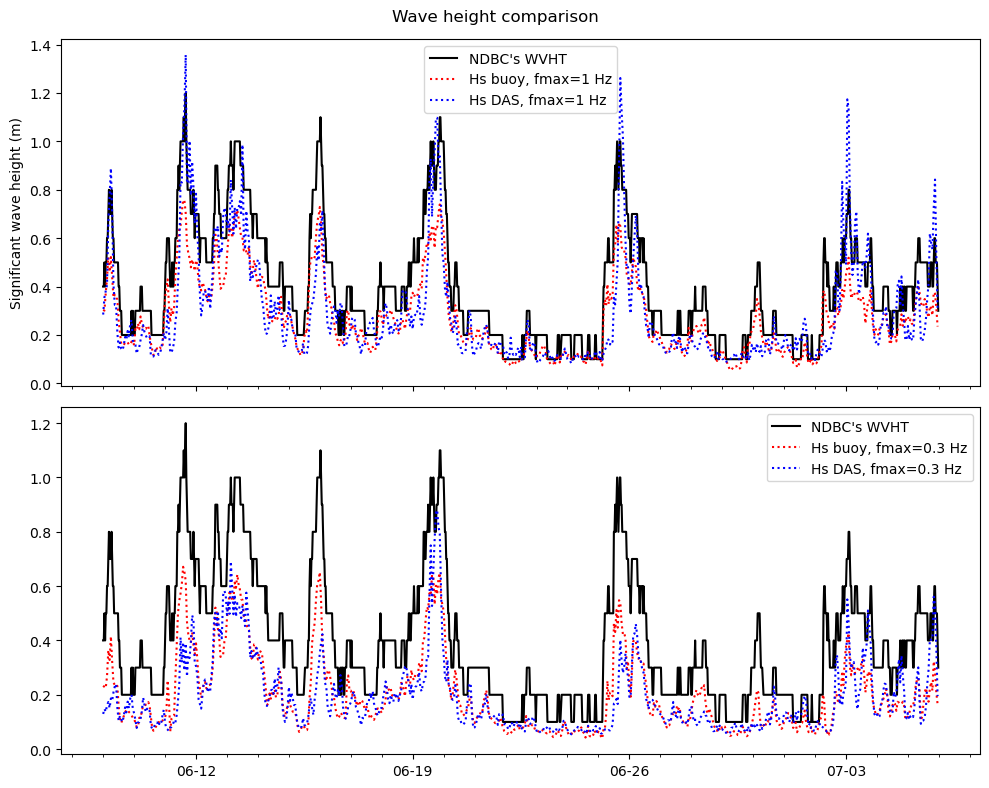

In [154]:
# Plot
fig,ax = plt.subplots(2,1,sharex=True,figsize=(10,8))
ax[0].plot(ndatem,WVHT,'k',label='NDBC\'s WVHT')
ax[0].plot(sdatem,Hs_buoy_1Hz,'r:',label='Hs buoy, fmax=1 Hz')
ax[0].plot(sdatem,Hs_DAS_1Hz,'b:',label='Hs DAS, fmax=1 Hz')
ax[0].set_ylabel('Significant wave height (m)')
ax[0].legend()
ax[1].plot(ndatem,WVHT,'k',label='NDBC\'s WVHT')
ax[1].plot(sdatem,Hs_buoy_p3Hz,'r:',label='Hs buoy, fmax=0.3 Hz')
ax[1].plot(sdatem,Hs_DAS_p3Hz,'b:',label='Hs DAS, fmax=0.3 Hz')
ax[1].legend()
ax[0].xaxis.set_major_formatter(date_form)
ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax[0].xaxis.set_minor_locator(mdates.DayLocator(interval=1))
fig.suptitle('Wave height comparison')
fig.tight_layout()

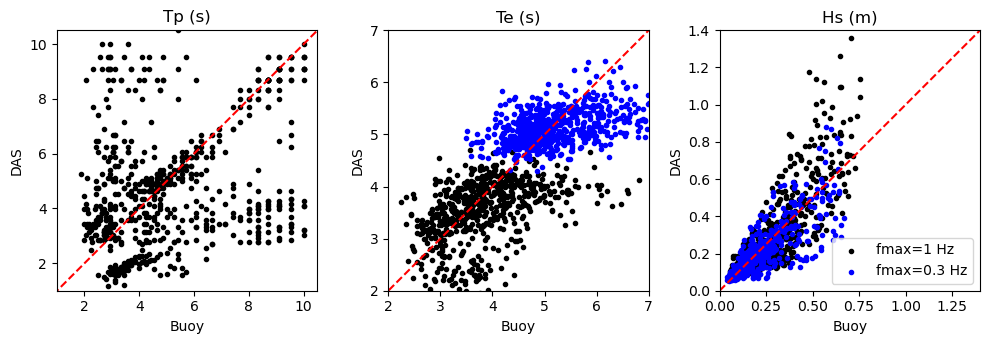

In [171]:
fig,ax = plt.subplots(1,3,figsize=(10,4))
ax[0].scatter(Tp_buoy,Tp_DAS,c='k',marker='.')
ax[0].plot([0,11],[0,11],'r--')
ax[0].set_aspect('equal')
ax[0].set_xlabel('Buoy')
ax[0].set_ylabel('DAS')
ax[0].set_xlim([1,10.5])
ax[0].set_ylim([1,10.5])
ax[0].set_title('Tp (s)')
ax[1].scatter(Te_buoy_1Hz,Te_DAS_1Hz,c='k',marker='.')
ax[1].scatter(Te_buoy_p3Hz,Te_DAS_p3Hz,c='b',marker='.')
ax[1].plot([0,11],[0,11],'r--')
ax[1].set_aspect('equal')
ax[1].set_xlabel('Buoy')
ax[1].set_ylabel('DAS')
ax[1].set_xlim([2,7])
ax[1].set_ylim([2,7])
ax[1].set_title('Te (s)')
ax[2].scatter(Hs_buoy_1Hz,Hs_DAS_1Hz,c='k',marker='.',label='fmax=1 Hz')
ax[2].scatter(Hs_buoy_p3Hz,Hs_DAS_p3Hz,c='b',marker='.',label='fmax=0.3 Hz')
ax[2].legend(loc='lower right')
ax[2].plot([0,2],[0,2],'r--')
ax[2].set_aspect('equal')
ax[2].set_xlabel('Buoy')
ax[2].set_ylabel('DAS')
ax[2].set_xlim([0,1.4])
ax[2].set_ylim([0,1.4])
ax[2].set_title('Hs (m)')
fig.tight_layout()


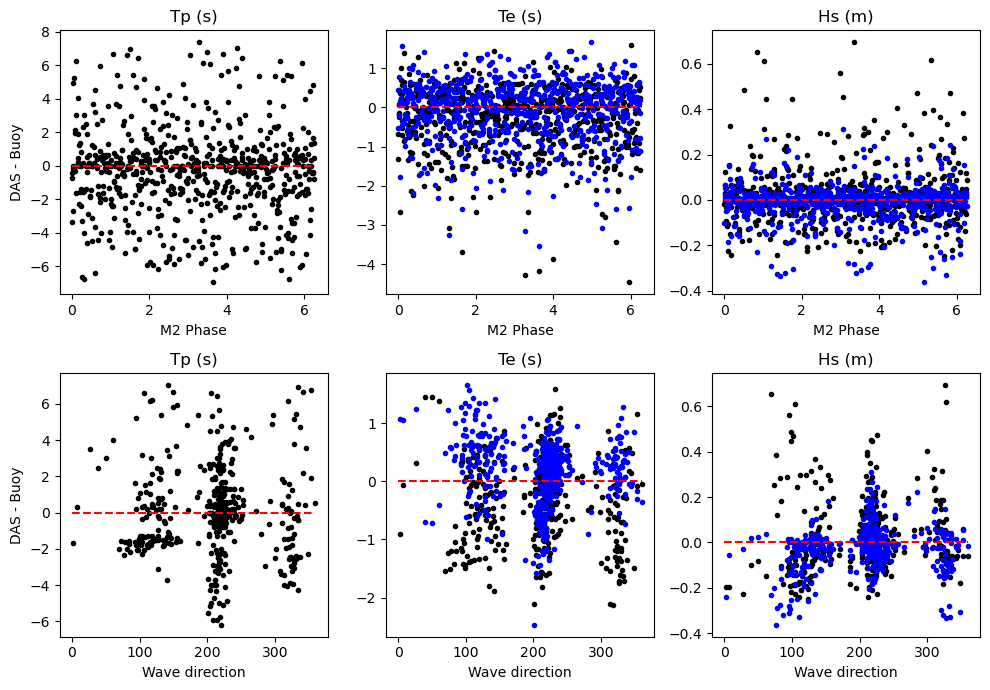

In [187]:
dTp = Tp_DAS - Tp_buoy
dTe1 = Te_DAS_1Hz - Te_buoy_1Hz
dTe2 = Te_DAS_p3Hz - Te_buoy_p3Hz
dHs1 = Hs_DAS_1Hz - Hs_buoy_1Hz
dHs2 = Hs_DAS_p3Hz - Hs_buoy_p3Hz

fig,ax = plt.subplots(2,3,figsize=(10,7))
ax[0,0].scatter(pm2,dTp,c='k',marker='.')
ax[0,1].scatter(pm2,dTe1,c='k',marker='.')
ax[0,1].scatter(pm2,dTe2,c='b',marker='.')
ax[0,2].scatter(pm2,dHs1,c='k',marker='.')
ax[0,2].scatter(pm2,dHs2,c='b',marker='.')
ax[0,0].plot([0,2*np.pi],[0,0],'r--')
ax[0,1].plot([0,2*np.pi],[0,0],'r--')
ax[0,2].plot([0,2*np.pi],[0,0],'r--')
ax[0,0].set_xlabel('M2 Phase')
ax[0,1].set_xlabel('M2 Phase')
ax[0,2].set_xlabel('M2 Phase')
ax[0,0].set_ylabel('DAS - Buoy')
ax[0,0].set_title('Tp (s)')
ax[0,1].set_title('Te (s)')
ax[0,2].set_title('Hs (m)')
ax[1,0].scatter(MWD2,dTp,c='k',marker='.')
ax[1,1].scatter(MWD2,dTe1,c='k',marker='.')
ax[1,1].scatter(MWD2,dTe2,c='b',marker='.')
ax[1,2].scatter(MWD2,dHs1,c='k',marker='.')
ax[1,2].scatter(MWD2,dHs2,c='b',marker='.')
ax[1,0].plot([0,360],[0,0],'r--')
ax[1,1].plot([0,360],[0,0],'r--')
ax[1,2].plot([0,360],[0,0],'r--')
ax[1,0].set_xlabel('Wave direction')
ax[1,1].set_xlabel('Wave direction')
ax[1,2].set_xlabel('Wave direction')
ax[1,0].set_ylabel('DAS - Buoy')
ax[1,0].set_title('Tp (s)')
ax[1,1].set_title('Te (s)')
ax[1,2].set_title('Hs (m)')
fig.tight_layout()